# Fast Neural Style Transfer

In [20]:
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

from fast_neural_style.transformer_net import TransformerNet
from fast_neural_style.utils import (
    gram_matrix, recover_image, tensor_normalizer
)
from fast_neural_style.loss_network import LossNetwork

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [24]:
!pwd

/host/space0/yamamoto-k/jupyter/notebook/B4-3b/fast-neural-style/notebooks


In [21]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [25]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET = "../../animal/"
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), 
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(), tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [27]:
STYLE_IMAGE = "../style_images/mosaic.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        tensor_normalizer()]
    )(style_img).unsqueeze(0)
    # assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
    style_img_tensor = style_img_tensor.to(device)

Sanity check:

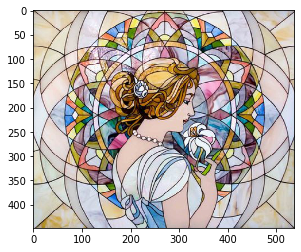

In [28]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

Precalculate gram matrices of the style image:

In [29]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
with torch.no_grad():
    style_loss_features = loss_network(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [30]:
style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [31]:
for i in range(len(style_loss_features)):
    tmp = style_loss_features[i].cpu().numpy()
    print(i, np.mean(tmp), np.std(tmp))

0 0.7157093 1.5986855
1 1.137745 2.8325207
2 1.4512998 4.9942584
3 0.37039497 1.4787791
4 0.07999754 0.4285575


In [32]:
for i in range(len(style_loss_features)):
    print(i, gram_style[i].numel(), gram_style[i].size())

0 4096 torch.Size([1, 64, 64])
1 16384 torch.Size([1, 128, 128])
2 65536 torch.Size([1, 256, 256])
3 262144 torch.Size([1, 512, 512])
4 262144 torch.Size([1, 512, 512])


## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [33]:
def save_debug_image(tensor_orig, tensor_transformed, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)

In [34]:
%mkdir -p ../debug

In [35]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [36]:
torch.set_default_tensor_type('torch.FloatTensor')
    
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    while True:
        for x, _ in train_loader:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)            
                        
            with torch.no_grad():
                xc = x.detach()

            features_y = loss_network(y)
            features_xc = loss_network(xc)

            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            total_loss = content_loss + style_loss + reg_loss 
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss ) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(x)
                save_debug_image(x, y.detach(), "../debug/{}.png".format(base_steps + count))
                transformer.train()
                
            if count >= steps:
                return

In [37]:
CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 1e4
REGULARIZATION = 1e-6
LOG_INTERVAL = 50

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)


In [38]:
len(train_loader)

250

In [39]:
train(1000, 0)

Fri Apr 30 04:42:31 2021 [50/1000] content: 16.80  style: 18.70  reg: 0.13 total: 35.633820
Fri Apr 30 04:42:37 2021 [100/1000] content: 18.62  style: 9.75  reg: 0.19 total: 28.555790
Fri Apr 30 04:42:44 2021 [150/1000] content: 18.27  style: 8.77  reg: 0.21 total: 27.243692
Fri Apr 30 04:42:50 2021 [200/1000] content: 17.53  style: 8.07  reg: 0.22 total: 25.809179
Fri Apr 30 04:42:57 2021 [250/1000] content: 16.74  style: 7.62  reg: 0.22 total: 24.574873
Fri Apr 30 04:43:03 2021 [300/1000] content: 16.28  style: 7.38  reg: 0.22 total: 23.880590
Fri Apr 30 04:43:10 2021 [350/1000] content: 16.09  style: 7.26  reg: 0.23 total: 23.578554
Fri Apr 30 04:43:16 2021 [400/1000] content: 15.67  style: 7.19  reg: 0.23 total: 23.085693
Fri Apr 30 04:43:22 2021 [450/1000] content: 15.18  style: 7.21  reg: 0.22 total: 22.617985
Fri Apr 30 04:43:29 2021 [500/1000] content: 14.80  style: 7.05  reg: 0.23 total: 22.079033
Fri Apr 30 04:43:35 2021 [550/1000] content: 14.57  style: 6.95  reg: 0.23 total

In [40]:
optimizer = Adam(transformer.parameters(), LR * 0.5)

In [41]:
train(3000, 1000)

Fri Apr 30 04:45:12 2021 [50/3000] content: 13.24  style: 6.47  reg: 0.22 total: 19.936453
Fri Apr 30 04:45:19 2021 [100/3000] content: 13.07  style: 6.47  reg: 0.22 total: 19.769600
Fri Apr 30 04:45:25 2021 [150/3000] content: 13.08  style: 6.37  reg: 0.23 total: 19.678953
Fri Apr 30 04:45:31 2021 [200/3000] content: 13.01  style: 6.48  reg: 0.23 total: 19.715973
Fri Apr 30 04:45:38 2021 [250/3000] content: 12.92  style: 6.44  reg: 0.22 total: 19.580490
Fri Apr 30 04:45:44 2021 [300/3000] content: 12.92  style: 6.27  reg: 0.23 total: 19.412951
Fri Apr 30 04:45:51 2021 [350/3000] content: 12.63  style: 6.25  reg: 0.23 total: 19.103968
Fri Apr 30 04:45:57 2021 [400/3000] content: 12.70  style: 6.30  reg: 0.22 total: 19.227421
Fri Apr 30 04:46:04 2021 [450/3000] content: 12.64  style: 6.32  reg: 0.22 total: 19.177456
Fri Apr 30 04:46:10 2021 [500/3000] content: 12.78  style: 6.37  reg: 0.23 total: 19.378853
Fri Apr 30 04:46:17 2021 [550/3000] content: 12.59  style: 6.22  reg: 0.23 total:

In [42]:
save_model_path = "../models/mosaic_4000_unstable_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [21]:
LOG_INTERVAL = 100
optimizer = Adam(transformer.parameters(), LR * 0.1)
train(6000, 4000)

Fri Jun 22 13:30:38 2018 [100/6000] content: 11.04  style: 7.17  reg: 0.22 total: 18.433414
Fri Jun 22 13:31:42 2018 [200/6000] content: 11.09  style: 7.10  reg: 0.22 total: 18.410851
Fri Jun 22 13:32:47 2018 [300/6000] content: 10.83  style: 7.16  reg: 0.22 total: 18.201572
Fri Jun 22 13:33:54 2018 [400/6000] content: 10.87  style: 7.14  reg: 0.22 total: 18.233467
Fri Jun 22 13:35:00 2018 [500/6000] content: 10.82  style: 7.14  reg: 0.22 total: 18.181248
Fri Jun 22 13:36:07 2018 [600/6000] content: 11.04  style: 7.12  reg: 0.22 total: 18.372707
Fri Jun 22 13:37:13 2018 [700/6000] content: 11.01  style: 7.20  reg: 0.22 total: 18.427862
Fri Jun 22 13:38:20 2018 [800/6000] content: 10.92  style: 7.03  reg: 0.22 total: 18.168201
Fri Jun 22 13:39:26 2018 [900/6000] content: 10.74  style: 7.05  reg: 0.22 total: 18.004976
Fri Jun 22 13:40:33 2018 [1000/6000] content: 10.87  style: 7.16  reg: 0.22 total: 18.247181
Fri Jun 22 13:41:39 2018 [1100/6000] content: 10.98  style: 7.19  reg: 0.22 tot

In [22]:
save_model_path = "../models/mosaic_10000_unstable_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [43]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

1006

In [44]:
transformer = transformer.eval()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


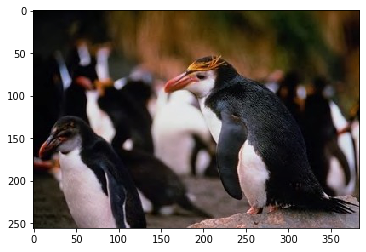

In [45]:
img = Image.open(fnames[70]).convert('RGB')
transform = transforms.Compose([
                                
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

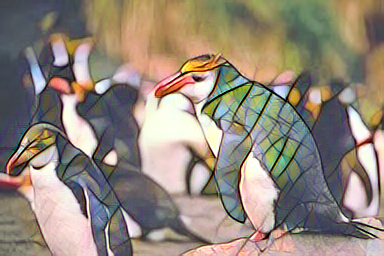

In [46]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


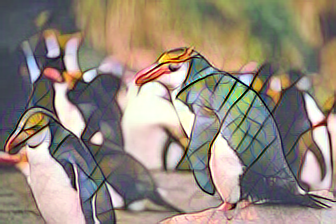

In [47]:
transform = transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 512, 512])


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


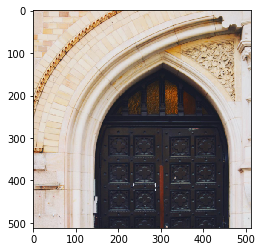

In [48]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

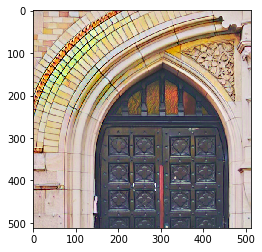

In [49]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 224, 224])


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


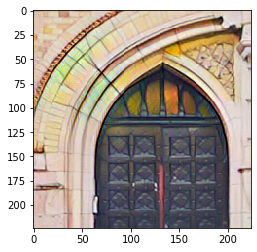

In [50]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [51]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")